# Parte 2: CNN con imágenes crudas

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import feature
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

saveImages = True

# Hiper parametros

dimensiones = 220
epochs = 23
batch = 130
std = 127
std_dev = 63
crop = 0
extractor = 'lbp'

In [2]:
# Paths of the folders containing the images
clean_covid_folder = 'dataset/clean_images/COVID'
clean_lung_opacity_folder = 'dataset/clean_images/Lung_Opacity'
clean_normal_folder = 'dataset/clean_images/Normal'
clean_viral_pneumonia_folder = 'dataset/clean_images/Viral_Pneumonia'
clean_folders = [clean_covid_folder, clean_lung_opacity_folder, clean_normal_folder, clean_viral_pneumonia_folder]

In [3]:
# Load the images of the folder with its label
def load_data(image_folder, label):
    data = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            tensor = tf.convert_to_tensor(img)
            data.append([tensor, label])
    return data

# Shows information of folders and the images
def info(folders, img):
    print("Image dimensions:", img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    counts = [len(os.listdir(folder)) for folder in folders]
    class_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
    data = {'Class': class_labels, 'Count': counts}
    df = pd.DataFrame(data).style.hide()
    
    print("Number of images per class")
    return df
    
# Create directories if it doesn't exist
def create_directories(folders):
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        
# Convert to string time
def get_str_time(time):
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    if hours == 0:
        if minutes == 0:
            return f'{seconds}s'
        return f'{minutes}m {seconds}s'
    return f'{hours}h {minutes}m {seconds}s'

# Calculate the metrics using sklearn.metrics
class_names = ['Covid', 'Lung Opacity', 'Normal', 'Pneumonia']
colors = ['blue', 'red', 'green', 'orange']
def get_metrics(model, X_test, y_test, time):

    # Get the model predictions
    y_pred  = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    
    # Get metrics
    report = classification_report(y_test, y_pred_classes, target_names=class_names)
    print(report)
    
    # Show charts
    ROC_auc(y_test, y_pred)
    
    # Show time
    print(f'Processing time: {time}\n')
    return report
    # accuracy = accuracy_score(y_test, y_pred_classes)
    # precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    # recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    # f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    # Output
    # results = [accuracy, precision, recall, f1, time]
    
    # df = pd.DataFrame({
    # 'Metric': ['Accuracy', 'Recall', 'Precision', 'F1Score', 'Training time'],
    # 'Scores': results
    # }).style.hide().set_properties(**{'text-align': 'left'})

# Show ROC chart for each class
def ROC_auc(y_test, y_pred):
    # Compute the fpr (false positive rate), tpr (true positive rate), and thresholds for each class
    n_classes = y_test.max() + 1
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot the ROC curves for each class
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='(AUC = %0.2f) %s' % (roc_auc[i], class_names[i]))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


# 1. DATA ANALYSIS

Image dimensions: (299, 299)


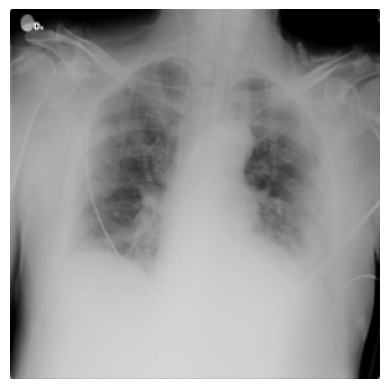

Number of images per class


Class,Count
COVID,3616
Lung Opacity,6012
Normal,10192
Viral Pneumonia,1345


In [4]:
# Show information
image = cv2.imread(clean_covid_folder+'/COVID-1.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=clean_folders, img=image)
df

# 4. TRAINING

Load the data of 'X' and 'y'

In [5]:
# Load lung images
# covid_data = load_data(standardized_covid_folder, 0)
# lung_opacity_data = load_data(standardized_lung_opacity_folder, 1)
# normal_data = load_data(standardized_normal_folder, 2)
# viral_pneumonia_data = load_data(standardized_viral_pneumonia_folder, 3)

covid_data = load_data(clean_covid_folder, 0)
lung_opacity_data = load_data(clean_lung_opacity_folder, 1)
normal_data = load_data(clean_normal_folder, 2)
viral_pneumonia_data = load_data(clean_viral_pneumonia_folder, 3)
data = covid_data + lung_opacity_data + normal_data + viral_pneumonia_data

# Split the list into two separate lists: one for the data and one for the labels
tensor_list  = [item[0] for item in data]
label_list = [item[1] for item in data]

# Combine the data and labels into an unordered list of tuples
combined_list = list(zip(tensor_list, label_list))
random.shuffle(combined_list)

# Separate the combined list into two separate lists again: one for the data and one for the labels
X, y = zip(*combined_list)
X, y = np.array(X), np.array(y)

Split the data into training and test sets

In [6]:
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocess the data
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Check the dimensions of the training and test sets
pd.DataFrame({
    'Variable': ['X train', 'y train',  'X test', 'y test'],
    'Dimensions': [X_train.shape, y_train_categorical.shape, X_test.shape, y_test_categorical.shape],
}).style.hide().set_properties(**{'text-align': 'left'})


Variable,Dimensions
X train,"(14815, 299, 299)"
y train,"(14815, 4)"
X test,"(6350, 299, 299)"
y test,"(6350, 4)"


# MLP

## Arquitectura 1

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()
model.fit(X_train, y_train_categorical, batch_size=batch, epochs=10, verbose=2)
train_time = get_str_time(time.time() - start)

Epoch 1/10
114/114 - 311s - loss: 406.6878 - accuracy: 0.6009 - 311s/epoch - 3s/step
Epoch 2/10
114/114 - 341s - loss: 0.9883 - accuracy: 0.8015 - 341s/epoch - 3s/step
Epoch 3/10
114/114 - 297s - loss: 0.3795 - accuracy: 0.8862 - 297s/epoch - 3s/step
Epoch 4/10
114/114 - 282s - loss: 0.2304 - accuracy: 0.9285 - 282s/epoch - 2s/step
Epoch 5/10
114/114 - 292s - loss: 0.1604 - accuracy: 0.9517 - 292s/epoch - 3s/step
Epoch 6/10
114/114 - 283s - loss: 0.1512 - accuracy: 0.9565 - 283s/epoch - 2s/step
Epoch 7/10
114/114 - 284s - loss: 0.1025 - accuracy: 0.9708 - 284s/epoch - 2s/step
Epoch 8/10
114/114 - 296s - loss: 0.0838 - accuracy: 0.9776 - 296s/epoch - 3s/step
Epoch 9/10
114/114 - 286s - loss: 0.0750 - accuracy: 0.9829 - 286s/epoch - 3s/step
Epoch 10/10
114/114 - 294s - loss: 0.0821 - accuracy: 0.9796 - 294s/epoch - 3s/step


199/199 [==============================] - 15s 71ms/step
              precision    recall  f1-score   support

       Covid       0.77      0.73      0.75      1085
Lung Opacity       0.66      0.75      0.70      1804
      Normal       0.83      0.78      0.80      3058
   Pneumonia       0.84      0.88      0.86       403

    accuracy                           0.77      6350
   macro avg       0.78      0.78      0.78      6350
weighted avg       0.77      0.77      0.77      6350



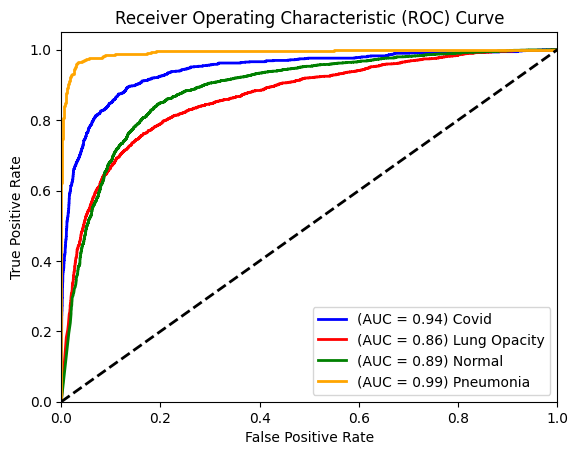

Processing time: 49m 33s



In [9]:
# Evaluate model    
results1 = get_metrics(model=model, X_test=X_test, y_test=y_test, time=train_time)